<a href="https://colab.research.google.com/github/jdcarrascali/Matematicas-del-aprendizaje-de-m-quina/blob/main/Occupancy_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación de data set y descripción de las variables

El data set "Occupancy detection" contiene observaciones ambientales tales como temperatura, humedad y CO2; estas fueron tomadas con el fin de detectar la presencia de personas en una habitación. Usaremos este data set para generar predicciones que premitan optimizar el funcionamiento de los sistemas de ventilación y aire acondicionado. Esto puede tener consecuencias positivas en la reducción de la cantidad de energía usada por estos sistemas y puede tener repercusiones positivas en la calidad de los mismos. 

A continuación describimos brevemente las etiquetas con las que trabajaremos

**Descripción de las covariables**


Date: Año, mes, día, hora, minuto, segundo en el que se realizó la medición

*  *Temperature:* Temperatura medida en grados Celsius
*   *Humidity:* Porcentaje de humedad relativa
*   *Luz:*  Medida en Lux
*   *CO2:*  Medido en partes por millón
*   *Humidity Ratio*, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
*   *Occupancy:* Presencia o ausencia. Se asigna 1 o -1, respectivamente.

In [2]:
#Librerias utilizadas
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import weibull_min
from scipy.optimize import minimize
style.use('ggplot') 


from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree


drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
#Montaje de la carpeta de trabajo
os.chdir('/content/drive/MyDrive/svm')

#Lectura de data sets

#Entrenamiento
data_occupancy=pd.read_csv('datatraining.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":object,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)
#Validación
data_test=pd.read_csv('datatest.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":object,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)

#test
data_test2=pd.read_csv('datatest2.txt',sep=',',header=0,names=["Date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"],
                               dtype={"Date":object,"Temperature":np.float64,"Humidity":np.float64,"Light":np.float64,
                              "CO2":np.float64,"HumidityRatio":np.float64,"Occupancy":int},parse_dates=[1],infer_datetime_format=True)


#Redondear a dos cifras
data_occupancy[['Temperature']] = data_occupancy[['Temperature']].astype(float).round(3)
data_occupancy[['CO2']] = data_occupancy[['CO2']].astype(float).round(3)
data_occupancy[['Humidity']] = data_occupancy[['Humidity']].astype(float).round(3)
data_occupancy["Occupancy"]=data_occupancy[['Occupancy']].replace(0,-1)
data_test[['Temperature']] = data_test[['Temperature']].astype(float).round(3)
data_test["Occupancy"]=data_test[['Occupancy']].replace(0,-1)
data_test2[['Temperature']] = data_test2[['Temperature']].astype(float).round(3)
data_test2["Occupancy"]=data_test2[['Occupancy']].replace(0,-1)

In [4]:
#Establecer formato de tiempo en la variable "Date"
data_occupancy['Date'] = pd.to_datetime(data_occupancy['Date'])

data_test['Date'] = pd.to_datetime(data_test['Date'])

data_test2['Date'] = pd.to_datetime(data_test2['Date'])

data_occupancy.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)
data_test2.reset_index(drop=True, inplace=True)


In [5]:
#Estadísticas descriptivas
data_occupancy.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731509,119.519375,606.546242,0.003863,-0.575341
std,1.016917,5.531210,194.755805,314.320874,0.000852,0.817964
min,19.000000,16.745000,0.000000,412.750000,0.002674,-1.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,-1.000000
50%,20.390000,26.222000,0.000000,453.500000,0.003801,-1.000000
75%,21.390000,30.533000,256.375000,638.833500,0.004352,-1.000000
max,23.180000,39.118000,1546.333333,2028.500000,0.006476,1.000000


In [5]:
print(data_occupancy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8143 non-null   datetime64[ns]
 1   Temperature    8143 non-null   float64       
 2   Humidity       8143 non-null   float64       
 3   Light          8143 non-null   float64       
 4   CO2            8143 non-null   float64       
 5   HumidityRatio  8143 non-null   float64       
 6   Occupancy      8143 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 445.4 KB
None


In [6]:
#Búsqueda de valores NA's
def missings(x):
            a = sum(x.isna())
            b = 100*np.mean(x.isna())
            c = pd.Series({"Missings": a,"%Missings": b})
            return(c)
data_occupancy.apply(missings,axis=0)
#No hay presencia de datos faltantes

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Missings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%Missings,0.0,0.0,0.0,0.0,0.0,0.0,0.0


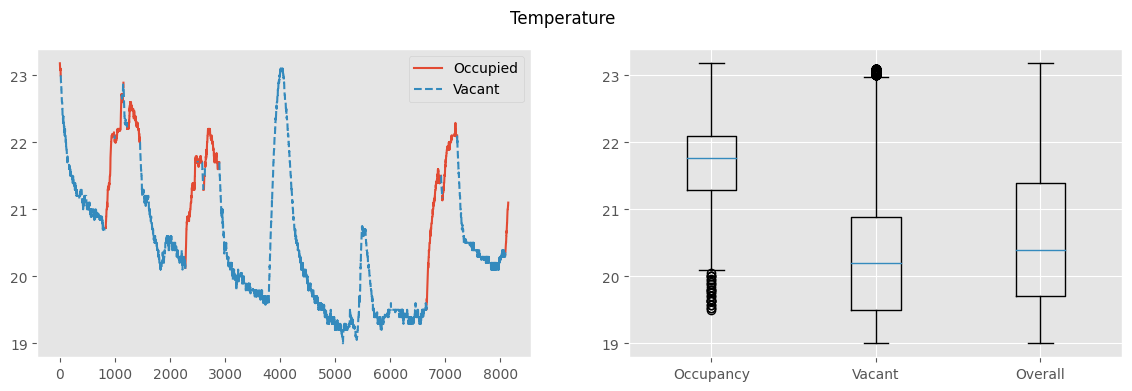

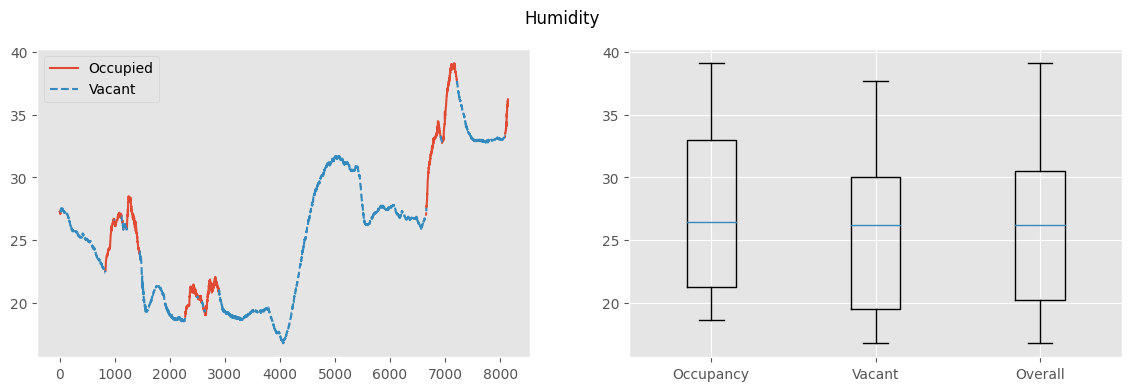

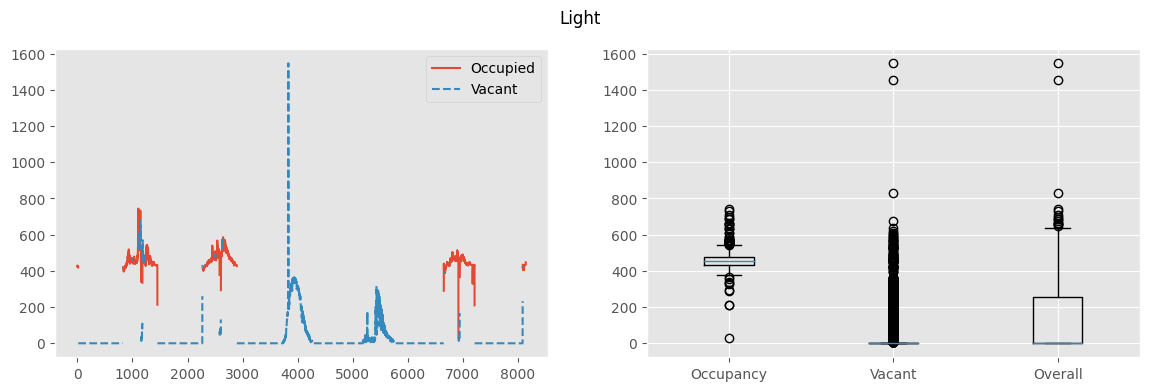

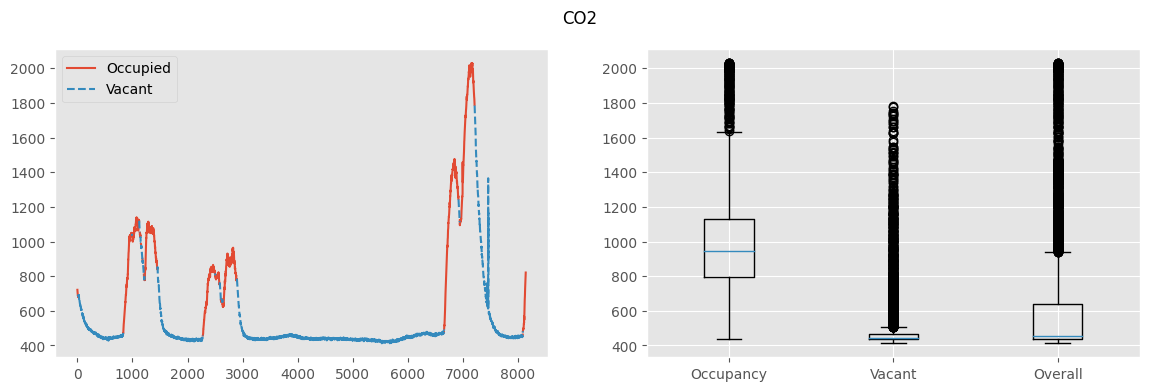

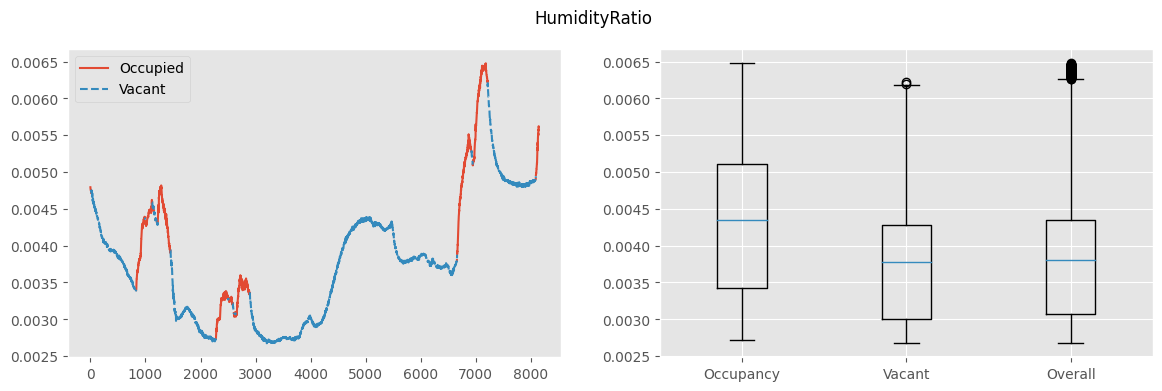

In [7]:
#Comportamiento temporal de las variables
#Redondear a dos cifras

def occupancy_plot(df, cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    
    fig.suptitle(cat)
    ax1.plot(np.where(df.Occupancy==1, df[cat], None), label='Occupied')
    ax1.plot(np.where(df.Occupancy==-1, df[cat], None), label='Vacant', ls='--')
    ax1.grid()
    ax1.legend()
    
    ax2.boxplot([df[cat][df.Occupancy==1], df[cat][df.Occupancy==-1], df[cat]])
    ax2.set_xticklabels(['Occupancy', 'Vacant', 'Overall'])


for i in range(1, 6):
    occupancy_plot(data_occupancy, data_occupancy.columns[i])

<ipython-input-8-94707adafaff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(data_occupancy.corr()))
<ipython-input-8-94707adafaff>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_occupancy.corr(),annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu")


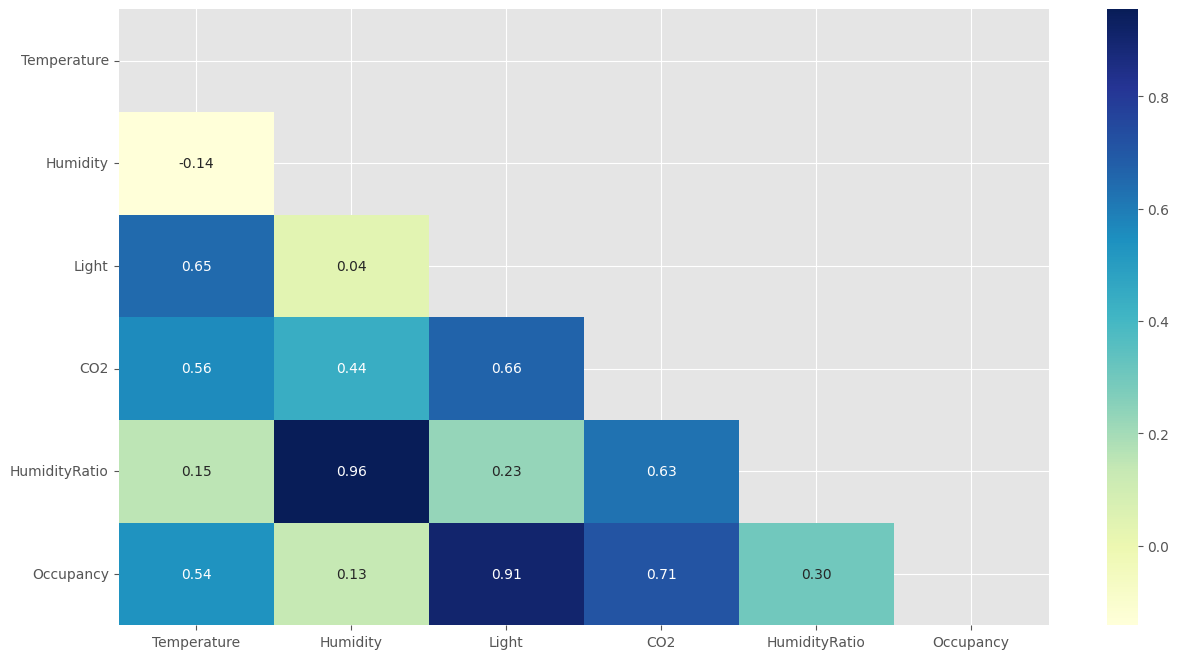

In [8]:
mask = np.triu(np.ones_like(data_occupancy.corr()))
plt.figure(figsize = (15,8))
sns.heatmap(data_occupancy.corr(),annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu")
plt.yticks(rotation=0)
plt.show()

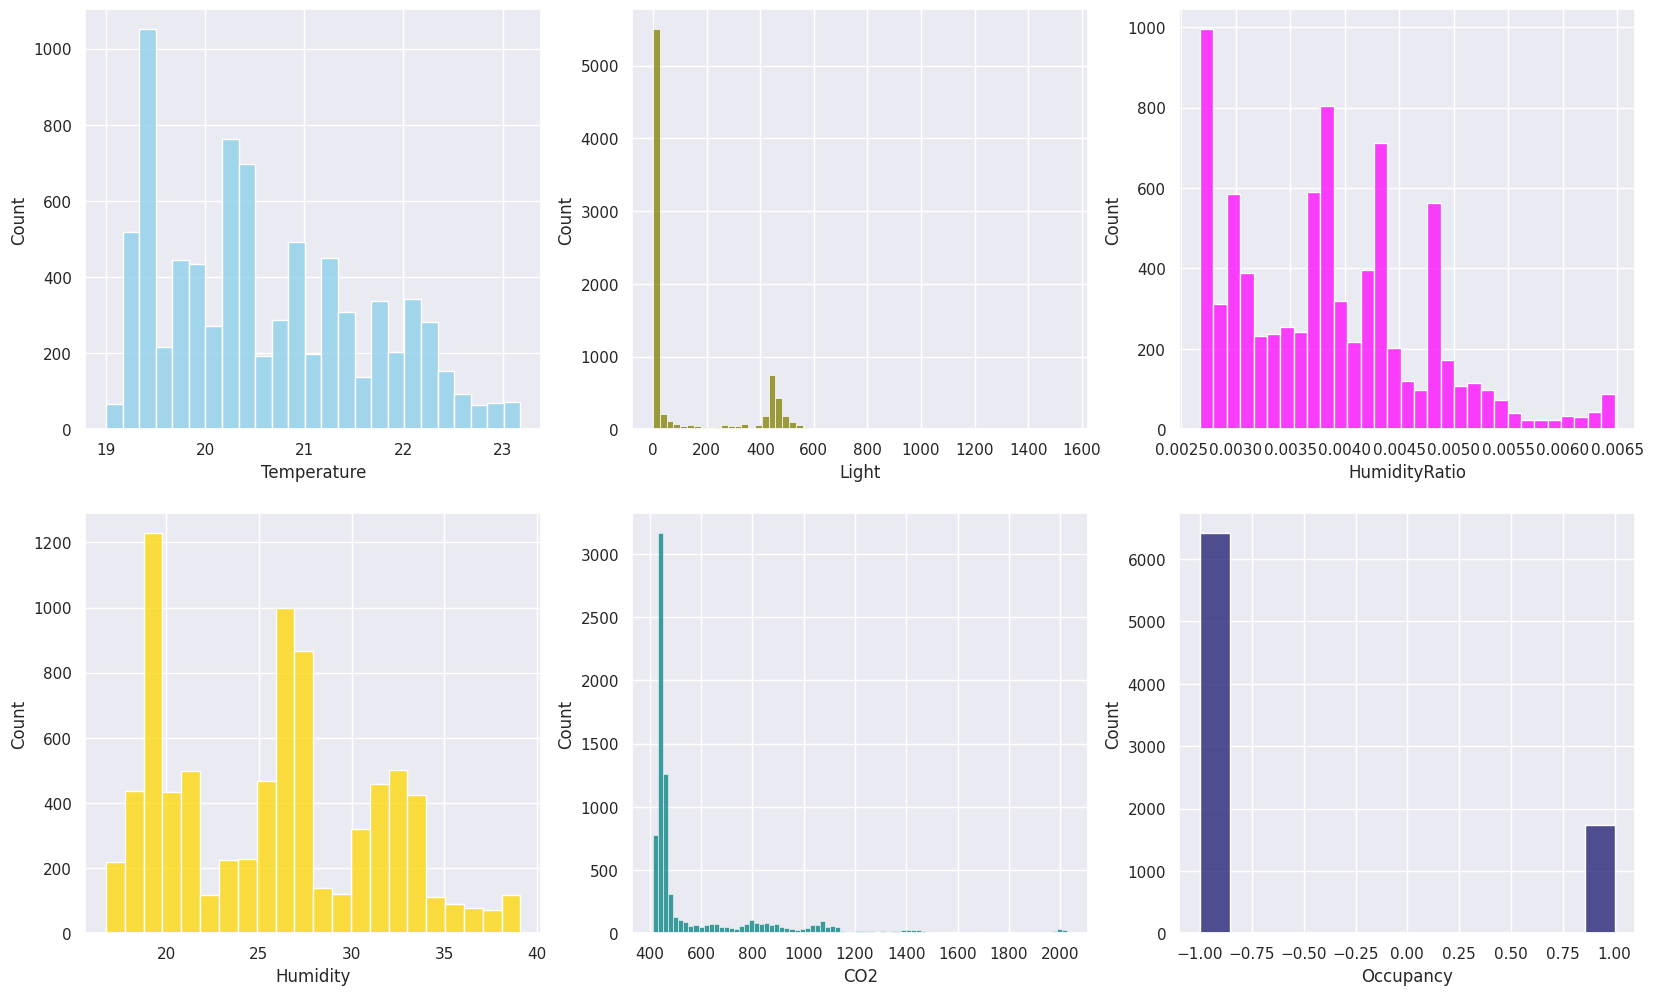

In [9]:
#Frecuencias
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

sns.histplot(data=data_occupancy["Temperature"], color="skyblue", ax=axs[0, 0])
sns.histplot(data=data_occupancy["Light"], color="olive", ax=axs[0, 1])
sns.histplot(data=data_occupancy["Humidity"], color="gold", ax=axs[1, 0])
sns.histplot(data=data_occupancy["CO2"], color="teal", ax=axs[1, 1])
sns.histplot(data=data_occupancy["HumidityRatio"], color="magenta", ax=axs[0, 2])
sns.histplot(data=data_occupancy["Occupancy"], color="midnightblue", ax=axs[1, 2])
plt.show()

Es importante resaltar que en el histograma de la variable occupancy, nuestra muestra no está balanceada. Por ello, debemos encontrar otras relaciones entre nuestros datos para lograr tener mejores predicciones. En particular, exploraremos el impacto de considerar la hora del día dentro de nuestras variables de interes.

In [6]:
hours_1 = []
hours_0 = []
for date in data_occupancy[data_occupancy['Occupancy'] == 1]['Date']:
    hours_1.append(date.hour)
for date in data_occupancy[data_occupancy['Occupancy'] == -1]['Date']:
    hours_0.append(date.hour)

<ipython-input-7-6a598c70bca4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(hours_1)
<ipython-input-7-6a598c70bca4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(hours_0)


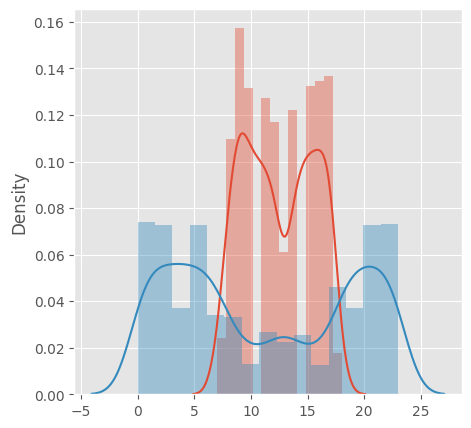

In [7]:
plt.figure(figsize=(5,5))
ax = sns.distplot(hours_1)
ax = sns.distplot(hours_0)

En este histograma observamos que entre las 7:00 y las 18:00 hay momentos en los que puede haber o no presencia de personas en la habitación. Sin embargo, tenemos certeza de que en las demás horas del día no hay presencia presencia de personas dentro de la habitación. Por esto, consideraremos la siguiente variable llamada "periodo":

In [8]:
#periodo de tiempo en el que puede haber presencia 
data_test['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in data_test['Date']]
data_test2['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in data_test2['Date']]
data_occupancy['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in data_occupancy['Date']]

In [9]:
#Preparación datos de entrenamiento
#Como no hay alta dispersión de los datos, no normalizamos
#Ya viene hecha la partición

X_train = data_occupancy.drop(columns=['Date', 'Occupancy'], axis=1)
y_train = data_occupancy['Occupancy']
X_validation = data_test.drop(columns=['Date', 'Occupancy'], axis=1)
y_validation = data_test['Occupancy']
X_test = data_test2.drop(columns=['Date', 'Occupancy'], axis=1)
y_test = data_test2['Occupancy']

#Elección métrica de de desempeño

Obtamos por elegir recall, esto es el número de total de elementos identificados correctamente como positivos del total de positivos verdadero:
\begin{equation*}
Recall=\frac{TP}{TP+FN}
\end{equation*}
La elección de esta métrica se debe a que consideramos más grave que el sistema no detecte la presencia de una persona pues esto hará que se vea comprometido la calidad de la ventilación o la temperatura, lo que puede ocasionar por ejemplo, problemas de la salud.

#Support vector machines

**Descripción de una SVM**

En principio, el ojetivo de una SVM es encontrar un hiperplano que maximice la distancia entre puntos que representen elementos de dos clases distintas. De manera que sea posible determinar si un elemento que no se encontraba inicialmente en el conjunto de entrenamiento, pertenece a alguna de estas dos clases.

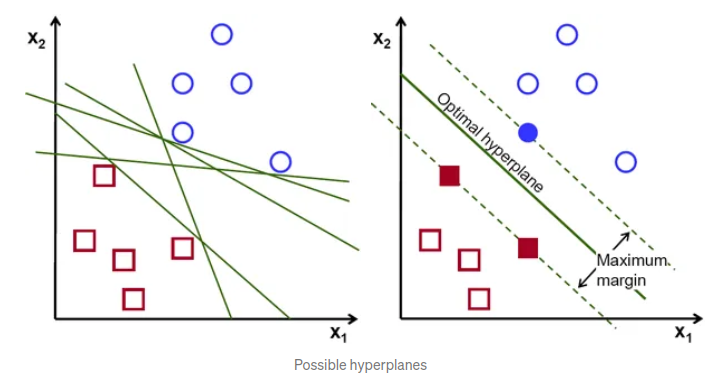



En este contexto, un hiperplano jugará el papel de una frontera de decisión, de manera que la clasificación de un punto se hará tomando en cuenta en que lado del hiperplano se encuentre. Es importante señalar que la dimensión del hiperplano depende de la cantidad de características con las que se sea entrenado el algoritm. De manera que sí se usan solo dos características, el hiperplano será una línea (una dimensión). En caso de que se trabaje con tres características, el hiperplano será un plano(dos dimensiones). Es decir, para *n* características se usará un hiperplano de *n-1* dimensiones.

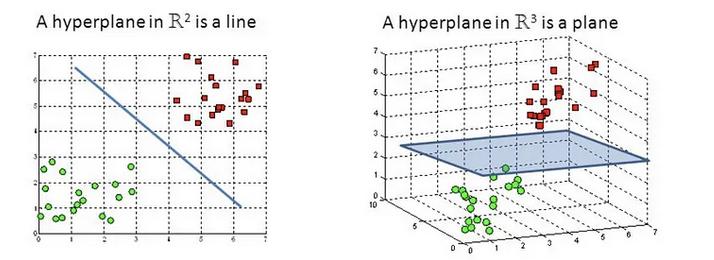

Los vectores de soporte serán los puntos del dataset que se encuentren más cerca del hiperplano. Más adelante haremos uso de estos para ajustar los parametros del modelo.

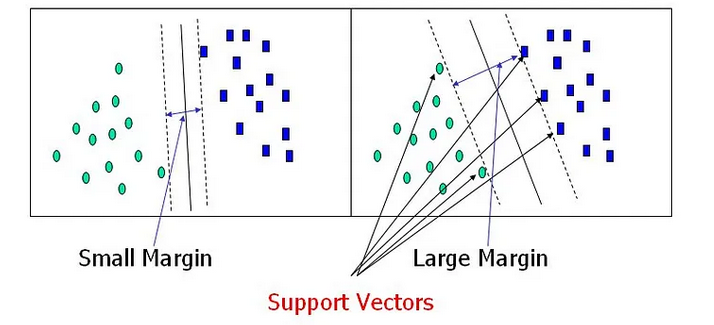

Referencia: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

##Implementación SVM

In [61]:
#Implementación Occupancy detection
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [62]:
y_pred = svm_model.predict(X_validation)
print("Recall score en el conjunto de validación para una SVM : {}%".format(round((recall_score(y_validation, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para una SVM : 98.04%


In [63]:
y_pred = svm_model.predict(X_test)
print("Recall score en el conjunto de test para una SVM : {}%".format(round((recall_score(y_test, y_pred, average='macro')*100),2)))
#Buen desempeño en validación y test

Recall score en el conjunto de test para una SVM : 98.56%


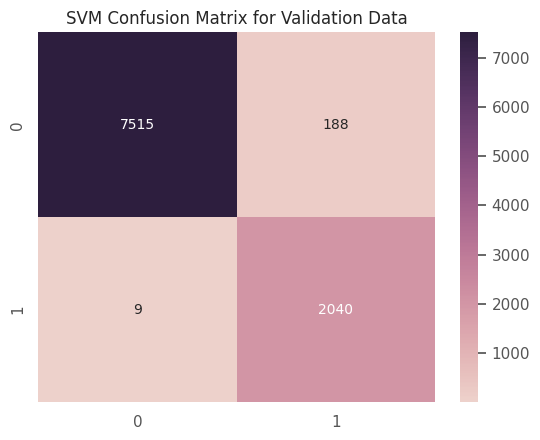

In [64]:
#Matriz de confusión para el desempeño en el conjunto de test
y_pred = svm_model.predict(X_test)
plt.title("SVM Confusion Matrix for Validation Data", fontdict={'fontsize':12})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt="d")

#Regresión logística

In [65]:
#Entrenamiento del modelo
log_reg=LogisticRegression(random_state=0).fit(X_train, y_train)

In [66]:
#Desempeño en el conjunto de entrenamiento
y_pred=log_reg.predict(X_train)
print("Recall score en el conjunto de entrenamiento para una regresión logística : {}%".format(round((recall_score(y_train, y_pred, average='macro')*100),2)))

Recall score en el conjunto de entrenamiento para una regresión logística : 98.95%


In [67]:
#Desempeño en el conjunto de test
y_pred=log_reg.predict(X_validation)
print("Recall score en el conjunto de validación para una regresión logística : {}%".format(round((recall_score(y_validation, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para una regresión logística : 98.22%


In [68]:
#Desempeño en el conjunto de test
y_pred=log_reg.predict(X_test)
print("Recall score en el conjunto de validación para una regresión logística : {}%".format(round((recall_score(y_test, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para una regresión logística : 99.11%


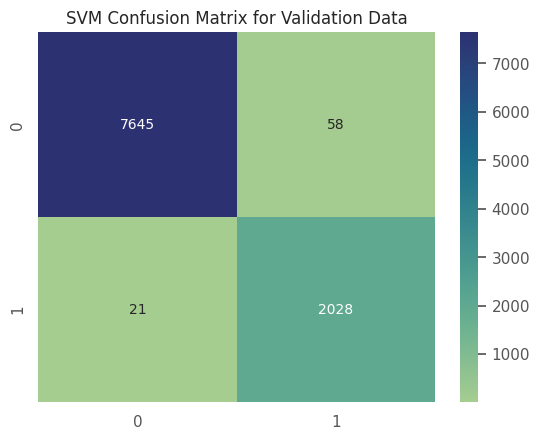

In [69]:
plt.title("SVM Confusion Matrix for Validation Data", fontdict={'fontsize':12})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap="crest", annot=True, fmt="d")

#K-nearest neighbor

In [76]:
from sklearn.neighbors import KNeighborsClassifier
# Optimización de parametros para knn
n_neighbors_list = [7,15,45,135] #Posibles parametros para k
weights_list = ['uniform', 'distance']
metric_list = ['euclidean', 'manhattan']
accuracies = {}
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            knn_model.fit(X_train, y_train)
            y_pred=knn_model.predict(X_validation)
            accuracy =recall_score(y_validation, y_pred, average='macro')
            accuracies[str(n)+"/"+weight+"/"+metric] = accuracy

In [77]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Recall score'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Recall score")
fig.update_layout(title={'text': "Recall score for Different Hyper-Parameters",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)


Del gráfico anterior observamos que:




*   Un valor adecuado para k se encuentra entre 45 y 135.
*   Cualquier distancia que se elija va a funcionar para hacer la clasificación siempre y cuando se mantenga la condición de usar el valor adecuado de k. 

*  Lo mismo aplica para la elección de los pesos.

Procedemos a implementar nuestro modelo:








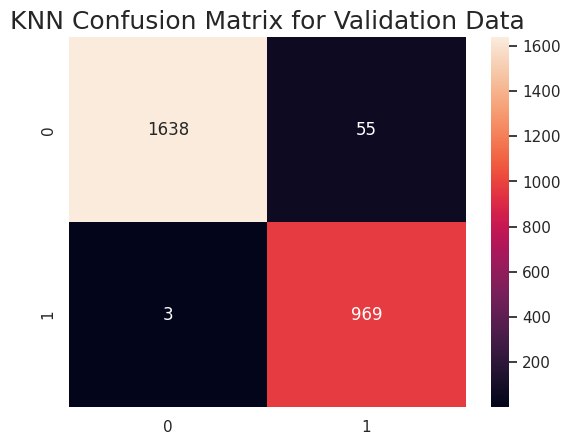

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=135)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_validation)
plt.title("KNN Confusion Matrix for Validation Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_validation, y_pred), annot=True, fmt="d")

In [81]:
print("Recall score en el conjunto de validación para KNN: {}%".format(round((recall_score(y_validation, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para KNN: 98.14%


#Decision trees

**Descripción del algoritmo**

Un árbol de decisión es una estructura parecida a un diagrama de flujo donde cada nodo interno representa un test sobre alguna característica, cada hoja del árbol representa una etiqueta y las ramas son la regla básica de decisión para asignarle una etiqueta a alguna observación. El siguiente diagrama representa el funcionamiento de un árbol de decisión para determinar si lloverá o no.
<center>
<div>
<img src="https://miro.medium.com/v2/resize:fit:720/0*PB7MYQfzyaLaTp1n" width="400" />


**Ganancia de información**

Está técnica es usada para decidir que característica se debe debe elegir a cada paso durante la construcción del árbol. En principio, queremos que el árbol sea lo más pequeño posible, para ello al elegir las ramificaciones del árbol queremos extraer los nodos que representen las cantidades de información más fundamentales. En este orden de ideas, las división se hará de manera que en cada iteración se obtendrá una ganancia de información hasta que esta sea 0. La medida de información que se usa es la **impuresa de Gini** que mide la verosimilitud de una mala clasificación de una instancia que no hizo parte del entrenamiento del modelo. Sin embargo,támbien podemos trabajar con entriopía,  modificando algunos aspectos del algoritmo.

Formalmente. la entropía de una variable aleatoria $V$ que toma los valores $v_k$, se define como:

\begin{equation*}  
    H(V) = -\sum_k P(v_k) \log_2(v_k)
\end{equation*}

**Ventajas**


*   Son un algoritmo fácil de entender e implementar.
*   Pueden tratar con datos númericos y categorícos.
*   Son resistentes a datos atípicos, por lo que requieren poco preprocesamiento. 


**Desventajas**



*   Son propensas a generar sobreajuste.
*   Se debe ser cuidadoso con la optimización de hiperparametros.
*   Se pueden introducir sesgos sí alguna clase del data set tiene mayor dominancia.

**Referencia:** https://towardsdatascience.com/decision-tree-in-machine-learning-e380942a4c96





In [19]:
#Entrenamiento del modelo
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [43]:
#Visualización del árbol
import graphviz 
dot_data = tree.export_graphviz(clf, out_file="tree.dpt",filled=True, rounded=True,special_characters=True) 
!dot -Tpng tree.dot -o tree.png #Convertir el archivo generado a png

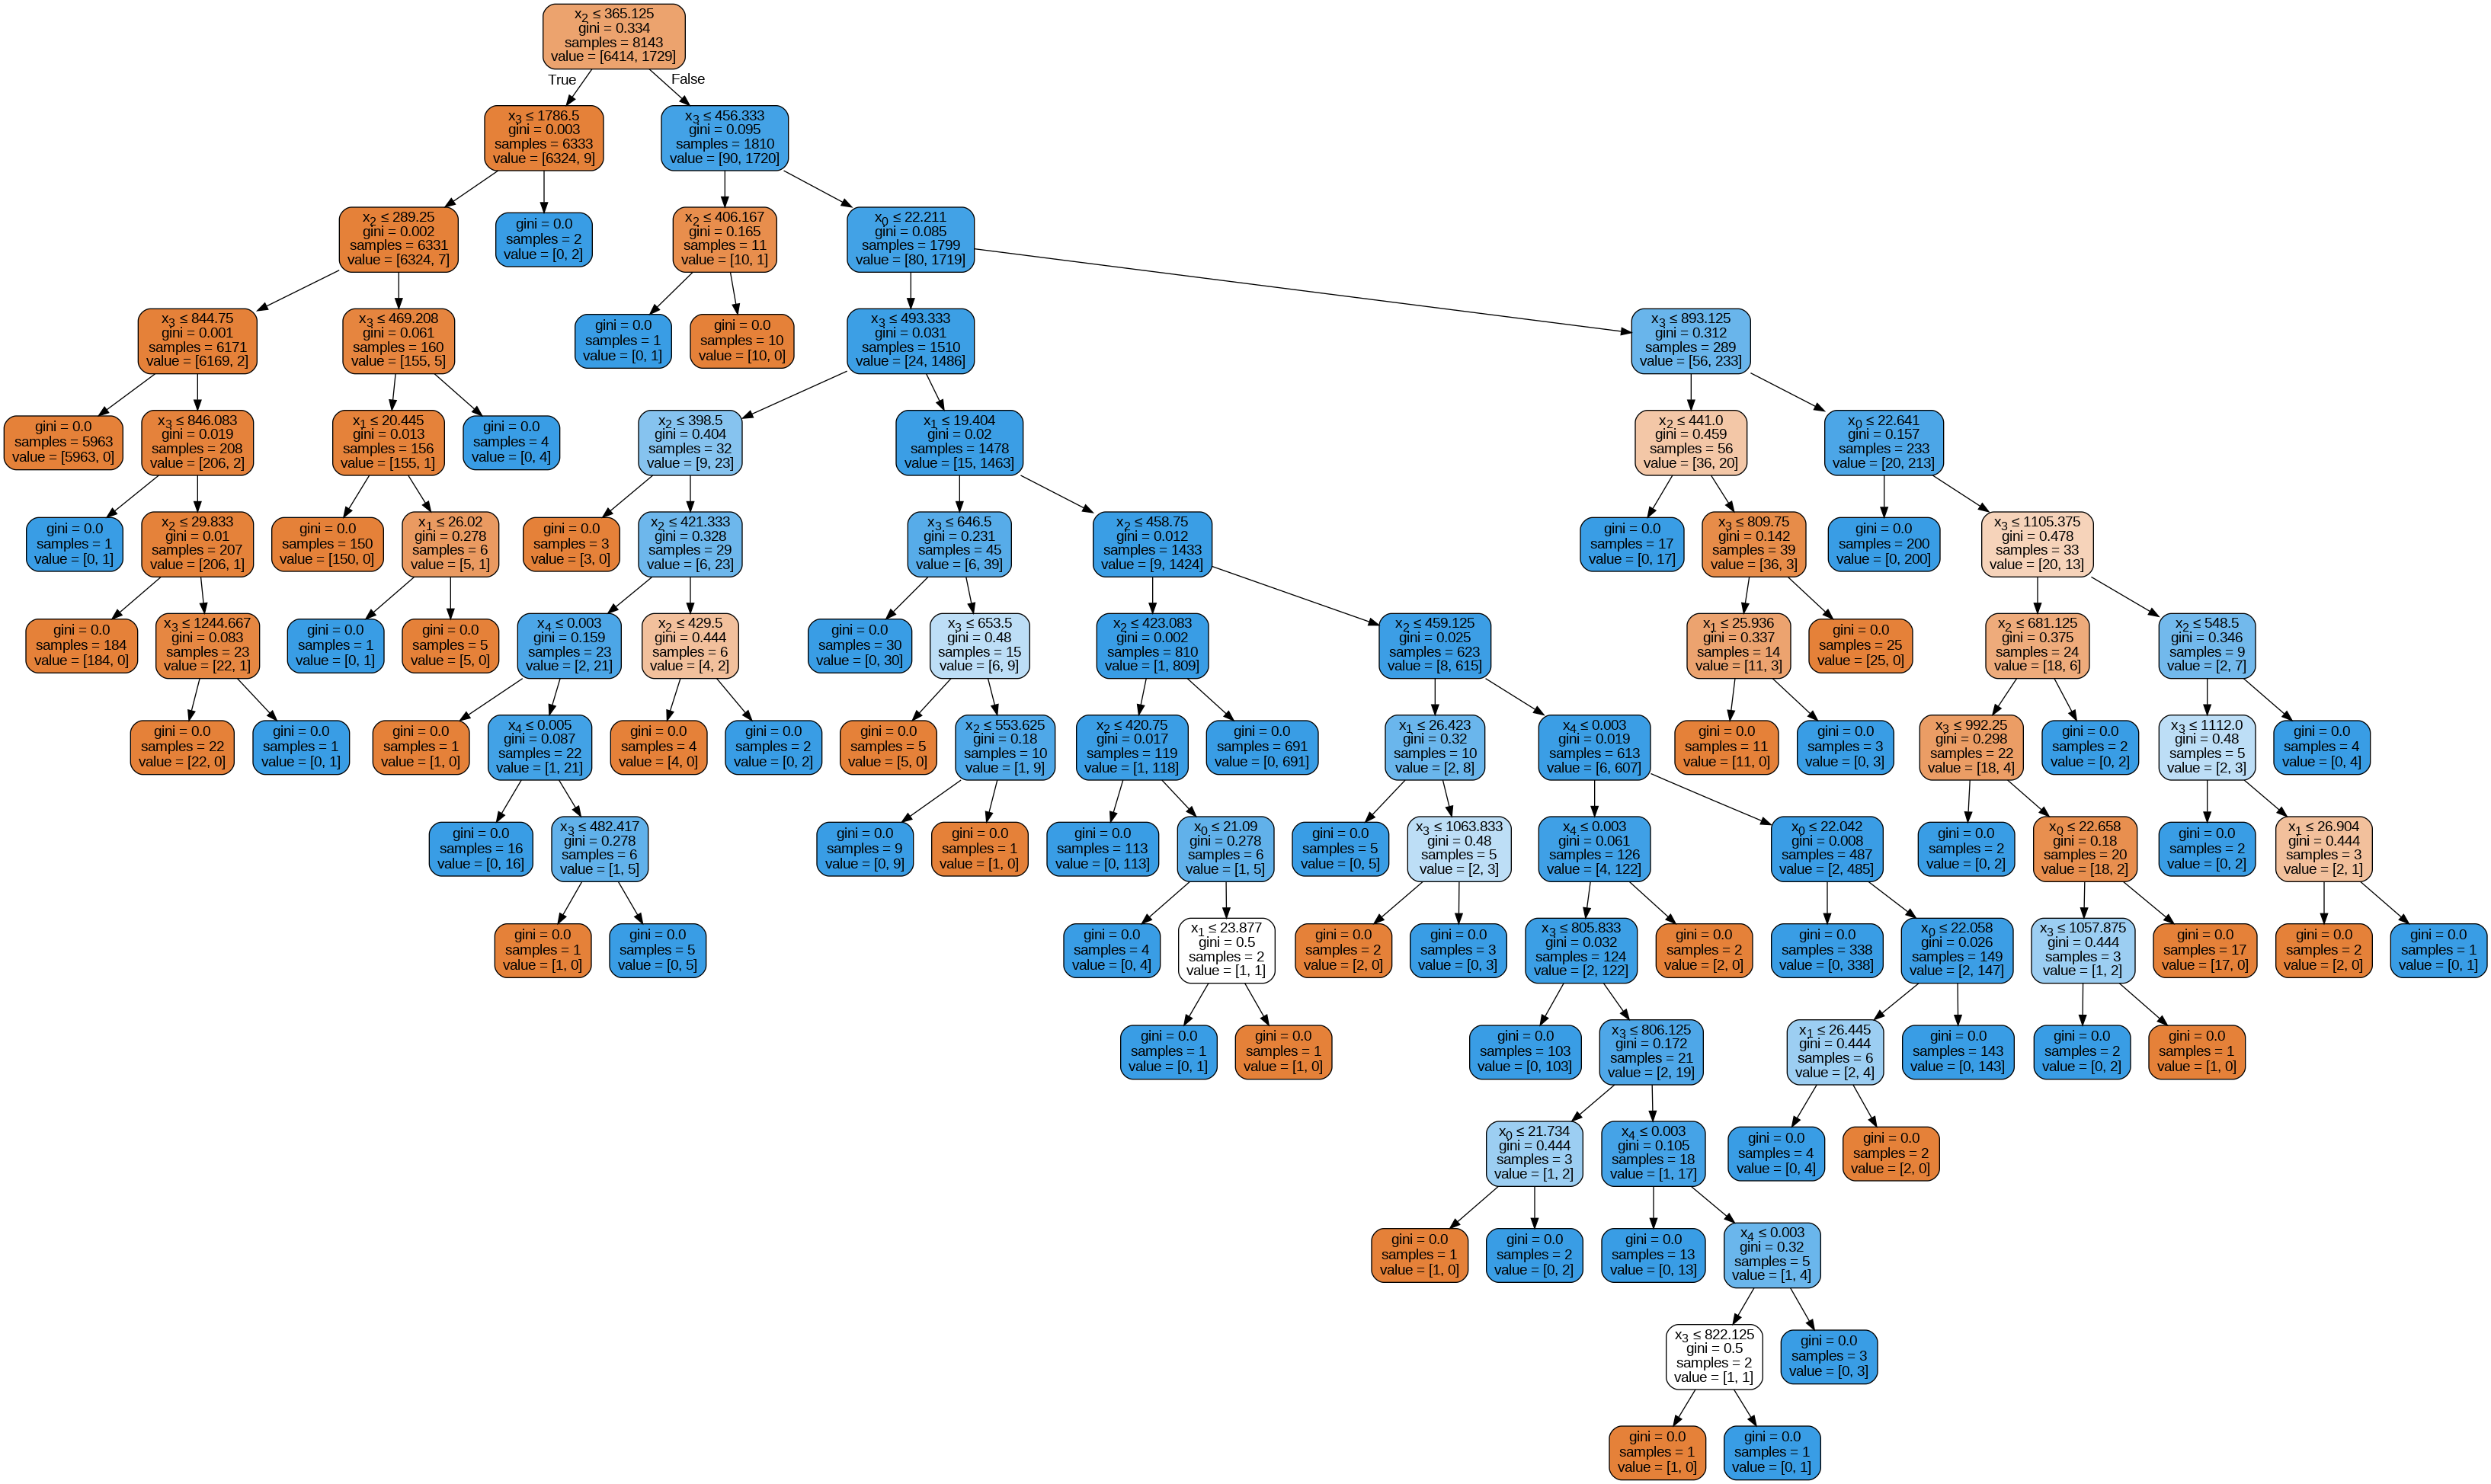

#Random forest

In [ ]:
# Numero de árobloes del bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Numero de características a considerar en cada split
max_features = ['auto', 'sqrt']
# Maximo número de niveles del árbol
max_depth = [2,4]
# Minimo número de muestras para dividir en un nodo
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

